# 1.MORDM OPTIMIZATION

# 1.1 Generate random policies

In [1]:
import pandas as pd
import numpy as np

from ema_workbench import load_results
from ema_workbench import Scenario

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

In [2]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import parcoords

import seaborn as sns
import matplotlib.pyplot as plt


ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Re-evaluation

In [3]:
# from ema_workbench import load_results

# results_deep = []
# convergence_all = []

# for i in range(5):
#     print(i)
#     result, convergence = load_results(f'../results/mordm_7500_rp_scenario{i}.tar.gz')
#     results_deep.append(result)
#     convergence_all.append(convergence)

In [4]:
# from ema_workbench import Policy

# policies = []
# for i, result in enumerate(results_deep):
#     outcomes_of_interest = result.iloc[:, :-3]
#     for j, row in outcomes_of_interest.iterrows():
#         policy = Policy(f'scenario {i} policy {j}', **row.to_dict())
#         policies.append(policy)

In [5]:
from problem_formulation import get_model_for_problem_formulation

# We use the original problem formulation to account for the RfR policies
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     reeevaluation_results = evaluator.perform_experiments(500, policies=policies)
    
# experiments_reev, outcomes_reev = reeevaluation_results

<Logger EMA (DEBUG)>

In [7]:
# from ema_workbench import save_results
# save_results((experiments_reev, outcomes_reev), f'../results/mordm_exp_2_1000.tar.gz')

experiments_reev, outcomes_reev = load_results('../results/mordm_exp_2_1000.tar.gz') 
outcomes_reev_df = pd.DataFrame.from_dict(outcomes_reev)

[MainProcess/INFO] results loaded succesfully from C:\Users\hidde\OneDrive\Documenten\EPA\Model Based Decision Making\EPA1361\final assignment\results\mordm_exp_2_1000.tar.gz


Comparing both cells below we can see how we have 42 unique policies.

In [8]:
experiments_reev.iloc[:,19:-3].duplicated().value_counts()

True     20958
False       42
dtype: int64

In [9]:
experiments_reev['policy'].nunique()

42

We now only chose the policies that keep the number of deaths under the threshold in ALL scenarios

In [10]:
outcomes_reev_df.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,2.100000e+04,2.100000e+04,2.100000e+04,21000.000000,21000.000000
mean,9.174717e+07,9.998493e+07,1.751971e+09,3407.984925,0.009067
std,3.406452e+08,2.086492e+07,2.994190e+08,7980.440903,0.030620
min,0.000000e+00,6.087036e+07,9.759000e+08,0.000000,0.000000
25%,1.544874e+06,8.173593e+07,1.572700e+09,112.189787,0.000105
50%,1.299621e+07,1.017962e+08,1.828800e+09,831.723645,0.001412
75%,4.840653e+07,1.158001e+08,2.015900e+09,2762.519602,0.005346
max,3.043916e+09,1.380248e+08,2.131200e+09,117778.445391,0.464258


In [11]:
outcomes_reev_df['policy']= experiments_reev['policy']
policy_names = outcomes_reev_df.policy.unique()

max_num_deaths = 0.0001 * 3 * 5

policies_of_interest = []
for policy in policy_names:
    policy_df = outcomes_reev_df[outcomes_reev_df['policy'] == policy]
    policy_df_logical = policy_df['Expected Number of Deaths'] > max_num_deaths
    type(policy_df_logical)
    if policy_df_logical.any():
        continue
    else:
        policies_of_interest.append(policy)

policies_of_interest

[]

We can see that there is no policy that obeys the threshold under all scenarios. We therefore calculate the robustness using the thresholds. This gives us an idea of how far off we are.

In [12]:
outcomes_reev_df_death= outcomes_reev_df[outcomes_reev_df['Expected Number of Deaths']<=max_num_deaths]
outcomes_reev_df_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,policy
0,2.783543e+06,1.158001e+08,1.572700e+09,179.850459,0.000142,scenario 0 policy 0
1,0.000000e+00,1.158001e+08,1.572700e+09,0.000000,0.000000,scenario 0 policy 0
2,0.000000e+00,1.158001e+08,1.572700e+09,0.000000,0.000000,scenario 0 policy 0
3,9.324408e+04,1.158001e+08,1.572700e+09,6.036863,0.000006,scenario 0 policy 0
5,2.700068e+06,1.158001e+08,1.572700e+09,178.331037,0.000139,scenario 0 policy 0
...,...,...,...,...,...,...
20988,1.014472e+07,6.087036e+07,1.828800e+09,545.680922,0.001139,scenario 4 policy 7
20989,9.778430e+06,6.087036e+07,1.828800e+09,645.111252,0.000651,scenario 4 policy 7
20993,8.841605e+06,6.087036e+07,1.828800e+09,540.934409,0.001111,scenario 4 policy 7
20995,4.810262e+06,6.087036e+07,1.828800e+09,254.312887,0.000532,scenario 4 policy 7


In [13]:
import functools

def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e3 # makes numbers nicer CAREFUL WITH UNITS
    
SMALLER = 'SMALLER'


max_num_deaths = 0.0001 * 3 * 5
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

Expected_Annual_Damage = costs
Dike_Investment_Costs = functools.partial(robustness, SMALLER, max_dike_costs)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, max_num_deaths)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, max_rfr_costs)
Evacuation_Costs = costs

No handles with labels found to put in legend.


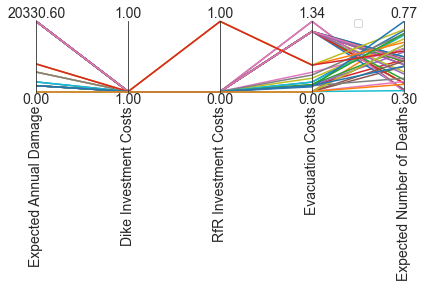

In [14]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines


funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths,
         'RfR Investment Costs':RfR_Investment_Costs,       
         'Evacuation Costs': Evacuation_Costs}

total_scores = {}
for policy in np.unique(experiments_reev['policy']):
    scores = {}
    logical = experiments_reev['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes_reev.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T#.reset_index(drop=True)
limits = parcoords.get_limits(data)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.legend()
plt.show()

In [15]:
data_death = data.sort_values(by=['Expected Number of Deaths']).tail()
data_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
scenario 2 policy 9,5642.665950,1.0,0.0,0.315184,0.684
scenario 3 policy 4,1706.663501,1.0,0.0,0.130888,0.686
scenario 0 policy 0,2783.542839,1.0,0.0,0.179850,0.706
scenario 3 policy 0,7987.168664,1.0,1.0,0.504389,0.712
scenario 3 policy 2,1706.663501,1.0,0.0,0.090304,0.766


These are the 5 policies that are the most robust in terms of Death mitigation

In [16]:
data_rfr = data[data['RfR Investment Costs'] == 1.0]
data_rfr

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
scenario 3 policy 0,7987.168664,1.0,1.0,0.504389,0.712
scenario 3 policy 3,7987.168664,1.0,1.0,0.504389,0.628
scenario 3 policy 5,7987.168664,1.0,1.0,0.504389,0.570


These are the policies which are below the RfR investment cost threshold defined by RWS. Since we want to propose a policy that is likely to be approved by the RWS, the policies that are the RfR investment costs threshold are chosen for further investigation. Additionally, the best performing policy in terms of Death Minimalization is also further investigated, due to it meeting the threshold set by the Delta Commission. 

In [17]:
# ADAPTIVE POLICIES

# df_lol = experiments_reev[experiments_reev['policy'] == data_death.index[-1]].iloc[:1,19:-3]
# df_lol = df_lol.append(experiments_reev[experiments_reev['policy'] == data_rfr.index[0]].iloc[:1,19:-3])
# df_lol = df_lol.append(experiments_reev[experiments_reev['policy'] == data_damage.index[-1]].iloc[:1,19:-3])
# df_lol

In [18]:
# ADAPTIVE POLICIES

# df_lol_2 = outcomes_reev_df[outcomes_reev_df['policy'] == data_rfr.index[0]]

In [19]:
data_damage = data.sort_values(by=['Expected Annual Damage']).head()
data_damage = data_damage.sort_values(by=['Expected Number of Deaths']).head()
data_damage

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
scenario 4 policy 5,0.0,1.0,0.0,0.0,0.308
scenario 4 policy 7,0.0,1.0,0.0,0.0,0.350
scenario 0 policy 5,0.0,1.0,0.0,0.0,0.468
scenario 4 policy 4,0.0,1.0,0.0,0.0,0.610
scenario 0 policy 1,0.0,1.0,0.0,0.0,0.680


In [20]:
potential_policies = [policy for policy in data_rfr.index]
potential_policies.append(data_death.index[-1])

df_potential_policies = outcomes_reev_df[outcomes_reev_df['policy'].isin(potential_policies)]

In [21]:
df_potential_policies.to_csv('results/outcomes_reev_df.csv')

## FIND A COUPLE EXTRA POLICIES

In [22]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines

limits = parcoords.get_limits(data_policies)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_policies)

for i, (name, color) in enumerate(zip(data_policies.index ,sns.color_palette())):
    paraxes.plot(data_policies.iloc[i].to_frame().T, color=color, label=name)

# we invert this axis so direction of desirability is the same  
paraxes.invert_axis('Expected Annual Damage')
paraxes.invert_axis('Evacuation Costs')
paraxes.legend()

plt.show()

NameError: name 'data_policies' is not defined

In [23]:
outcomes_reev_df_policy  = outcomes_reev_df[outcomes_reev_df.policy == 'scenario 3 policy 0']
outcomes_reev_df_policy.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000
mean,3.342249e+07,1.300070e+08,1.060500e+09,1686.873825,0.002661
std,1.705510e+08,1.491608e-08,0.000000e+00,3490.984454,0.014551
min,0.000000e+00,1.300070e+08,1.060500e+09,0.000000,0.000000
25%,1.548206e+06,1.300070e+08,1.060500e+09,120.511279,0.000111
50%,6.783201e+06,1.300070e+08,1.060500e+09,564.471280,0.000465
75%,2.857263e+07,1.300070e+08,1.060500e+09,1864.936206,0.002000
max,2.685754e+09,1.300070e+08,1.060500e+09,42995.528439,0.202109


In [24]:
experiments_reev.iloc[:,19:-1].drop_duplicates('policy').to_csv('results/all_policies.csv')

In [25]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments_reev['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes_reev[outcome.name], 
                         "policy":experiments_reev['policy'],
                         "scenario":experiments_reev['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

<ipython-input-25-2bee466a20d0>:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()


In [37]:
max_regret

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 0 policy 0,2.636115e+09,5.492971e+07,5.968000e+08,90609.453869,0.328842
scenario 0 policy 1,2.619949e+09,6.757200e+07,9.861000e+08,90605.738463,0.328748
scenario 0 policy 2,1.994488e+09,5.333367e+07,1.040000e+09,107702.788224,0.331005
scenario 0 policy 3,3.041396e+09,5.146514e+07,6.837000e+08,90739.025305,0.329031
scenario 0 policy 4,3.041396e+09,5.698102e+07,5.505000e+08,90605.738463,0.328748
scenario 0 policy 5,2.777292e+09,4.547483e+07,7.683000e+08,101428.231477,0.374739
scenario 1 policy 0,1.004771e+09,5.267459e+07,1.070700e+09,52765.217324,0.075488
scenario 1 policy 1,3.041396e+09,2.375683e+07,5.505000e+08,68401.798239,0.245967
scenario 1 policy 10,2.630699e+09,1.962378e+07,8.529000e+08,68401.798239,0.245967


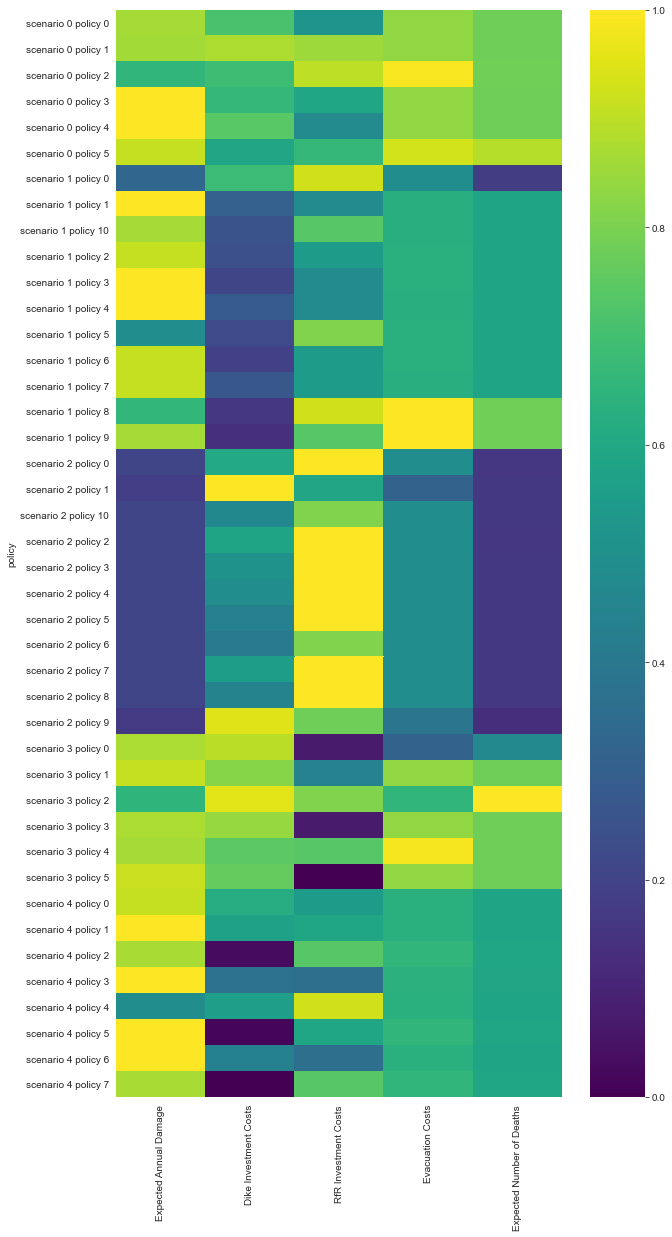

In [28]:
max_regret = pd.DataFrame(max_regret)

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=False, ax=ax)
plt.savefig('results/policy_heatmap.png')
plt.show()

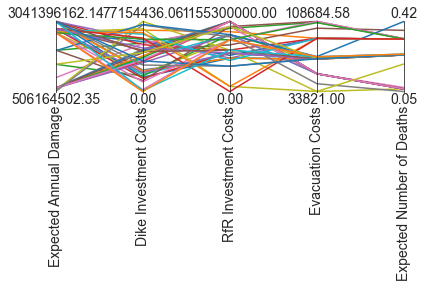

In [29]:
colors = sns.color_palette()

data_regret = max_regret

limits = parcoords.get_limits(data_regret)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_regret)
plt.show()

In [30]:
regret_death = max_regret.sort_values(by=['Expected Number of Deaths']).head()
regret_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 2 policy 9,5.061645e+08,7.327201e+07,8.992000e+08,42179.834017,0.054615
scenario 2 policy 0,6.287829e+08,4.655960e+07,1.155300e+09,52792.946914,0.067474
scenario 2 policy 2,6.287829e+08,4.504191e+07,1.155300e+09,52792.946914,0.067474
scenario 2 policy 7,6.287829e+08,4.264690e+07,1.155300e+09,52792.946914,0.067966
scenario 2 policy 6,6.287829e+08,3.147805e+07,9.375000e+08,52792.946914,0.067966


In [31]:
regret_evac = max_regret.sort_values(by=['Evacuation Costs']).head()
# regret_evac = regret_damage.sort_values(by=['Expected Number of Deaths']).head()
regret_evac

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 2 policy 1,5.500295e+08,7.715444e+07,6.814000e+08,33820.997400,0.068720
scenario 3 policy 0,2.654664e+09,6.913664e+07,8.460000e+07,33901.658198,0.198972
scenario 2 policy 9,5.061645e+08,7.327201e+07,8.992000e+08,42179.834017,0.054615
scenario 1 policy 0,1.004771e+09,5.267459e+07,1.070700e+09,52765.217324,0.075488
scenario 2 policy 7,6.287829e+08,4.264690e+07,1.155300e+09,52792.946914,0.067966


In [32]:
regret_damage = max_regret.sort_values(by=['Expected Annual Damage']).head()
# regret_damage = regret_damage.sort_values(by=['Expected Number of Deaths']).head()
regret_damage

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 2 policy 9,5.061645e+08,7.327201e+07,8.992000e+08,42179.834017,0.054615
scenario 2 policy 1,5.500295e+08,7.715444e+07,6.814000e+08,33820.997400,0.068720
scenario 2 policy 2,6.287829e+08,4.504191e+07,1.155300e+09,52792.946914,0.067474
scenario 2 policy 0,6.287829e+08,4.655960e+07,1.155300e+09,52792.946914,0.067474
scenario 2 policy 4,6.287829e+08,3.752958e+07,1.155300e+09,52792.946914,0.067966


In [33]:
# regret_policies = [regret_death.index[0], regret_evac.index[0], regret_damage.index[0]]
# regret_policies

# regret_policies_df = max_regret[max_regret.index.isin(regret_policies)]
# regret_policies_df

regret_policies_df_2 = pd.concat([regret_death, regret_evac, regret_damage], axis=0)
regret_policies_df_2 = regret_policies_df_2[~regret_policies_df_2.index.duplicated(keep='first')]
regret_policies_df_2

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 2 policy 9,5.061645e+08,7.327201e+07,8.992000e+08,42179.834017,0.054615
scenario 2 policy 0,6.287829e+08,4.655960e+07,1.155300e+09,52792.946914,0.067474
scenario 2 policy 2,6.287829e+08,4.504191e+07,1.155300e+09,52792.946914,0.067474
scenario 2 policy 7,6.287829e+08,4.264690e+07,1.155300e+09,52792.946914,0.067966
scenario 2 policy 6,6.287829e+08,3.147805e+07,9.375000e+08,52792.946914,0.067966
scenario 2 policy 1,5.500295e+08,7.715444e+07,6.814000e+08,33820.997400,0.068720
scenario 3 policy 0,2.654664e+09,6.913664e+07,8.460000e+07,33901.658198,0.198972
scenario 1 policy 0,1.004771e+09,5.267459e+07,1.070700e+09,52765.217324,0.075488
scenario 2 policy 4,6.287829e+08,3.752958e+07,1.155300e+09,52792.946914,0.067966


In [34]:
outcomes_reev_df_pol = data[data.index == 'scenario 2 policy 9']
outcomes_reev_df_pol

policy,scenario 0 policy 0,scenario 0 policy 1,scenario 0 policy 2,scenario 0 policy 3,scenario 0 policy 4,scenario 0 policy 5,scenario 1 policy 0,scenario 1 policy 1,scenario 1 policy 10,scenario 1 policy 2,...,scenario 3 policy 4,scenario 3 policy 5,scenario 4 policy 0,scenario 4 policy 1,scenario 4 policy 2,scenario 4 policy 3,scenario 4 policy 4,scenario 4 policy 5,scenario 4 policy 6,scenario 4 policy 7
scenario,,,,,,,,,,,,,,,,,,,,,


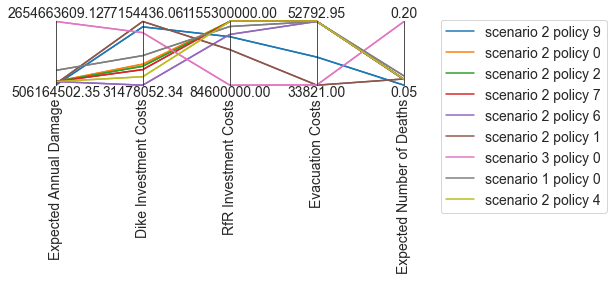

In [35]:
from ema_workbench.analysis import parcoords
import matplotlib.lines as mlines

limits = parcoords.get_limits(regret_policies_df_2)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_policies_df_2)

for i, (name, color) in enumerate(zip(regret_policies_df_2.index ,sns.color_palette())):
    paraxes.plot(regret_policies_df_2.iloc[i].to_frame().T, color=color, label=name)

paraxes.legend()

plt.show()

In [36]:
import pandas as pd
from sklearn import preprocessing

x = regret_policies_df_2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
regret_policies_df_norm = pd.DataFrame(x_scaled, columns=regret_policies_df_2.columns)


limits = parcoords.get_limits(max_regret_filtered_norm)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_policies_df_norm)
plt.show()

NameError: name 'max_regret_filtered_norm' is not defined

In [ ]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [ ]:
policy_regret_filtered = { key: policy_regret[key] for key in regret_policies_df.index}

In [ ]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
# axes = [axes[0,0], axes[1,0]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret_filtered.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
fig.autofmt_xdate()
plt.show()

## select some policies from second metric and make boxplots

# End of document